In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
counter_add = 0
counter_mul = 0
counter_sub = 0

In [3]:
def clear_counters():
    global counter_add, counter_mul, counter_sub
    counter_add, counter_mul, counter_sub = 0, 0, 0

In [4]:
def add(A, B):
  global counter_add
  n = len(A)
  C = [[None for _ in range(n)] for _ in range(n)]
  for i in range(n):
    for j in range(n):
      C[i][j] = A[i][j] + B[i][j]
      counter_add += 1
  return C


In [5]:
def sub(A, B):
  global counter_sub
  n = len(A)
  C = [[None for _ in range(n)] for _ in range(n)]
  for i in range(n):
    for j in range(n):
      C[i][j] = A[i][j] - B[i][j]
      counter_sub += 1
  return C

In [6]:
def add(X, Y):
    return X + Y

def sub(X, Y):
    return X - Y

In [7]:
def strassen(A, B):
    global counter_add, counter_mul, counter_sub
    
    n = len(A)

    if n == 1:
        counter_mul += 1
        return [[A[0][0] * B[0][0]]]

    if n == 2:
        counter_add += 4
        counter_mul += 8
        return (np.array(A) @ np.array(B)).tolist()

    C = [[None for _ in range(n)] for _ in range(n)]
    k = n // 2

    if n % 2 == 0:
        A11 = [row[:k] for row in A[:k]]
        A12 = [row[k:] for row in A[:k]]
        A21 = [row[:k] for row in A[k:]]
        A22 = [row[k:] for row in A[k:]]

        B11 = [row[:k] for row in B[:k]]
        B12 = [row[k:] for row in B[:k]]
        B21 = [row[:k] for row in B[k:]]
        B22 = [row[k:] for row in B[k:]]

        M1 = strassen(add(A11, A22), add(B11, B22))
        M2 = strassen(add(A21, A22), B11)
        M3 = strassen(A11, sub(B12, B22))
        M4 = strassen(A22, sub(B21, B11))
        M5 = strassen(add(A11, A12), B22)
        M6 = strassen(sub(A21, A11), add(B11, B12))
        M7 = strassen(sub(A12, A22), add(B21, B22))

        C11 = add(sub(add(M1, M4), M5), M7)
        C12 = add(M3, M5)
        C21 = add(M2, M4)
        C22 = add(sub(add(M1, M3), M2), M6)

        for i in range(k):
            for j in range(k):
                C[i][j] = C11[i][j]
                C[i][j + k] = C12[i][j]
                C[i + k][j] = C21[i][j]
                C[i + k][j + k] = C22[i][j]

    else:
        A = np.asarray(A)
        B = np.asarray(B)

        right_vector = (A[:-1, :] @ B[:, -1]).tolist()
        counter_mul += (n - 1) * n
        counter_add += (n - 1) * (n - 1)

        down_vector = (A[-1, :] @ B[:, :-1]).tolist()
        counter_mul += (n - 1) * n
        counter_add += (n - 1) * (n - 1)

        corner_element = (A[-1, :] @ B[:, -1]).item()
        counter_mul += n
        counter_add += (n - 1)

        C_sub = strassen(A[:-1, :-1].tolist(), B[:-1, :-1].tolist())

        last_col = A[:, -1]
        last_row = B[-1, :]

        for i in range(n - 1):
            for j in range(n - 1):
                C_sub[i][j] += last_col[i] * last_row[j]
                counter_add += 1
                counter_mul += 1
                C[i][j] = C_sub[i][j]

        for i in range(n - 1):
            C[i][n - 1] = right_vector[i]

        for j in range(n - 1):
            C[n - 1][j] = down_vector[j]

        C[-1][-1] = corner_element

    return C


In [8]:
def strassen(A, B, leaf_size=64):
    global counter_mul, counter_add, counter_sub

    n = A.shape[0]

    if n <= leaf_size:
        counter_add += n**2 * (n - 1)
        counter_mul += n**3
        return A @ B

    m = n if n % 2 == 0 else n + 1
    if m != n:
        A_padded = np.zeros((m, m), dtype=A.dtype)
        B_padded = np.zeros((m, m), dtype=B.dtype)
        A_padded[:n, :n] = A
        B_padded[:n, :n] = B
    else:
        A_padded = A
        B_padded = B

    k = m // 2

    A11 = A_padded[:k, :k]
    A12 = A_padded[:k, k:]
    A21 = A_padded[k:, :k]
    A22 = A_padded[k:, k:]

    B11 = B_padded[:k, :k]
    B12 = B_padded[:k, k:]
    B21 = B_padded[k:, :k]
    B22 = B_padded[k:, k:]

    M1 = strassen(add(A11, A22), add(B11, B22), leaf_size)
    M2 = strassen(add(A21, A22), B11, leaf_size)
    M3 = strassen(A11, sub(B12, B22), leaf_size)
    M4 = strassen(A22, sub(B21, B11), leaf_size)
    M5 = strassen(add(A11, A12), B22, leaf_size)
    M6 = strassen(sub(A21, A11), add(B11, B12), leaf_size)
    M7 = strassen(sub(A12, A22), add(B21, B22), leaf_size)

    C11 = M1 + M4 - M5 + M7
    C12 = M3 + M5
    C21 = M2 + M4
    C22 = M1 - M2 + M3 + M6

    C = np.zeros((m, m), dtype=A.dtype)
    C[:k, :k] = C11
    C[:k, k:] = C12
    C[k:, :k] = C21
    C[k:, k:] = C22

    if m != n:
        C = C[:n, :n]

    return C


In [9]:
A = [
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5]
]

B = [
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5]
]



In [11]:
add_counters = []
sub_counters = []
mul_counters = []
time_counters = []
mem_counters = []

In [ ]:
from random import randint
from random import uniform

def randomize_matrix(n):
    return [[uniform(1e-8, 1) for _ in range(n)] for _ in range(n)]

def check_mat(C, C_test, tol=1e-9):
    return np.allclose(C, C_test, atol=tol)

In [12]:
clear_counters()

In [13]:
import tracemalloc

correct_count = 1

for n in range(1, 1000):
    print("Computing n =", n)

    A = randomize_matrix(n)
    B = randomize_matrix(n)

    tracemalloc.start()
    start_time = time.time()

    A = np.array(A)
    B = np.array(B)

    if check_mat(strassen(A, B), np.dot(A, B).tolist()):
        correct_count += 1

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    mem_counters.append(peak / 10**6)
    time_counters.append(end_time - start_time)
    add_counters.append(counter_add)
    mul_counters.append(counter_mul)
    sub_counters.append(counter_sub)
    clear_counters()

Computing n = 1
Computing n = 2
Computing n = 3
Computing n = 4
Computing n = 5
Computing n = 6
Computing n = 7
Computing n = 8
Computing n = 9
Computing n = 10
Computing n = 11
Computing n = 12
Computing n = 13
Computing n = 14
Computing n = 15
Computing n = 16
Computing n = 17
Computing n = 18
Computing n = 19
Computing n = 20
Computing n = 21
Computing n = 22
Computing n = 23
Computing n = 24
Computing n = 25
Computing n = 26
Computing n = 27
Computing n = 28
Computing n = 29
Computing n = 30
Computing n = 31
Computing n = 32
Computing n = 33
Computing n = 34
Computing n = 35
Computing n = 36
Computing n = 37
Computing n = 38
Computing n = 39
Computing n = 40
Computing n = 41
Computing n = 42
Computing n = 43
Computing n = 44
Computing n = 45
Computing n = 46
Computing n = 47
Computing n = 48
Computing n = 49
Computing n = 50
Computing n = 51
Computing n = 52
Computing n = 53
Computing n = 54
Computing n = 55
Computing n = 56
Computing n = 57
Computing n = 58
Computing n = 59
Comput

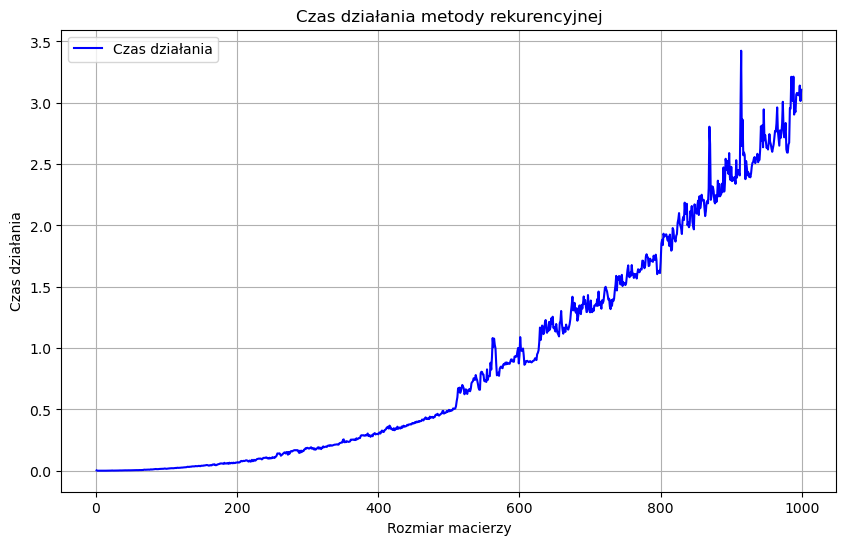

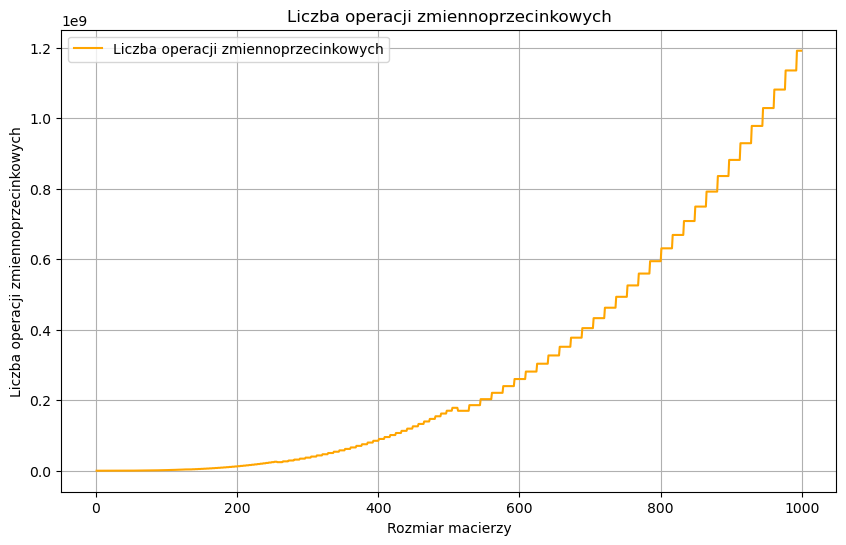

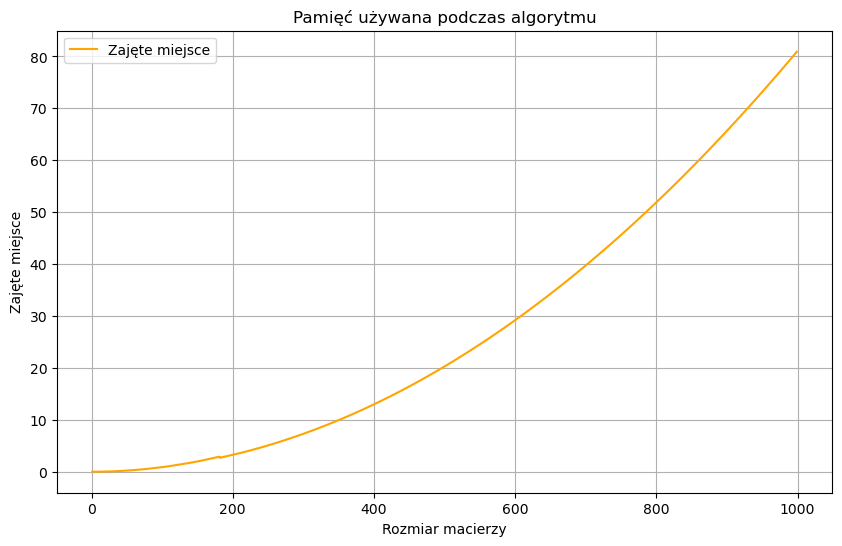

In [14]:
# Wykres 1: Czas działania metody rekurencyjnej
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(time_counters) + 1), time_counters, label="Czas działania", color='blue')
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas działania")
plt.title("Czas działania metody rekurencyjnej")
plt.legend()
plt.grid(True)
plt.show()

# Wykres 2: Liczba operacji zmiennoprzecinkowych
zmiennop = [add + sub + mul for add, sub, mul in zip(add_counters, sub_counters, mul_counters)]
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(zmiennop) + 1), zmiennop, label="Liczba operacji zmiennoprzecinkowych", color='orange')
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Liczba operacji zmiennoprzecinkowych")
plt.title("Liczba operacji zmiennoprzecinkowych")
plt.legend()
plt.grid(True)
plt.show()

# Wykres 2: Liczba zajętej pamięci
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mem_counters) + 1), mem_counters, label="Zajęte miejsce", color='orange')
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Zajęte miejsce")
plt.title("Pamięć używana podczas algorytmu")
plt.legend()
plt.grid(True)
plt.show()